In [33]:
import GCRCatalogs
from clevar import ClCatalog, MemCatalog
from clevar.match import MembershipMatch, get_matched_pairs
import clevar
clevar.__version__

'0.10.3'

In [67]:
import sys
sys.path.append('../')
from cluster_validation.plotting_functions import *

In [34]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib 

matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'figure.figsize': (10,8)})

In [47]:
import emcee
import corner


# 0 - opening catalogs

In [35]:
gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image' )

In [36]:
cosmo = gc_truth.cosmology

In [4]:
min_richness = 5
min_halo_mass = 1e13 #Msun

In [14]:
RM_cat = ClCatalog.read('../RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True)

In [16]:
halo_cat = ClCatalog.read('../halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True)

In [20]:
RM_cat.read_members('../RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)

In [21]:
halo_cat.read_members('../halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)

# 2 - associate redMaPPer detections to true DC2 halos

In [22]:
RM_cat._init_match_vals(True)
halo_cat._init_match_vals(True)

In [23]:
mt = MembershipMatch()

In [25]:
mt.load_matches(RM_cat, halo_cat, out_dir='../cosmoDC2_RM_match_cross_membership')

RM_cat
 * Total objects:    45,081
 * multiple (self):  43,211
 * multiple (other): 43,211
 * unique (self):    43,211
 * unique (other):   42,825
 * cross:            42,754

halo_cat
 * Total objects:    278,904
 * multiple (self):  75,514
 * multiple (other): 75,514
 * unique (self):    75,514
 * unique (other):   42,973
 * cross:            42,827


In [26]:
mt1, mt2 = get_matched_pairs(RM_cat, halo_cat, 'cross')

In [27]:
mt1.size, halo_cat.size, mt1.size/RM_cat.size,  mt1.size/halo_cat.size, 

(42754, 278904, 0.9483818016459262, 0.15329288930958324)

# 3 - Analyse mass richness relation

### Comparison to DES

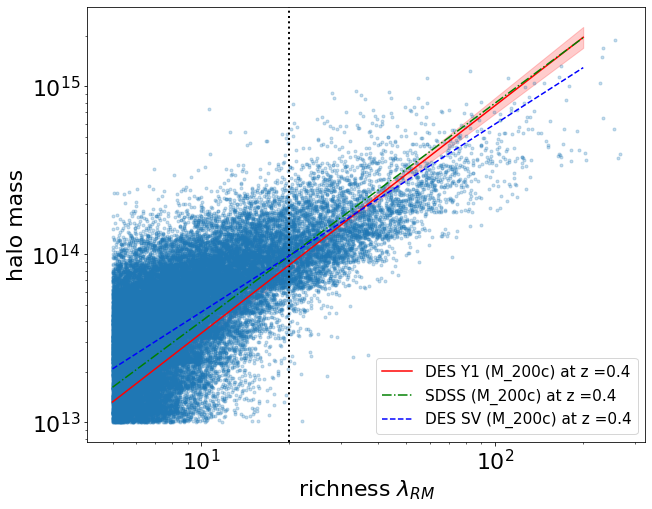

In [39]:
plt.loglog(mt1['mass'], mt2['mass'], '.',alpha=0.25)
plt.axvline(20, color='black', linestyle='dotted', lw=2)

plt.xlabel("richness $\\lambda_{RM}$")
plt.ylabel('halo mass')


#adding parametrization from litterature
ll = np.logspace(np.log10(min_richness), np.log10(200))

z0 = 0.4
Om_z0 = cosmo.Om0   

plt.fill_between(ll, M_DES_Y1_lim(ll, z0, 'min', Om_z0),M_DES_Y1_lim(ll, z0, 'max', Om_z0),alpha=0.2,color='r')

plt.plot(ll, M_DES_Y1(ll, z0, Om_z0), 'r-', alpha=1, label='DES Y1 (M_200c) at z ='+str(z0) )
plt.plot(ll, M_SDSS(ll, z0, Om_z0), 'g-.', alpha=1, label='SDSS (M_200c) at z ='+str(z0))
plt.plot(ll, M_DES_SV(ll, z0, Om_z0), 'b--', alpha=1, label='DES SV (M_200c) at z ='+str(z0))

plt.legend(fontsize='x-small')

### Fit of the relation

In [41]:
def mu_logM_lambda(redshift, logrichness, mu0, G_z_mu, G_lambda_mu):
    richness_0 = 40
    z_0 = 0.4
    return mu0 + G_z_mu*np.log10((1+redshift)/(1 + z_0)) + G_lambda_mu*(logrichness-np.log10(richness_0))

In [44]:
def sum_chi2(data, model, error=None):
    if error==None:
        y =  (data - model)**2
    else :
        y = (data - model)**2/error**2
    return np.sum(y)

In [45]:
def lnL(data, theta):
    mu0, G_z_mu, G_lambda_mu = theta
    return -0.5*sum_chi2(data[0],  mu_logM_lambda(data[1], data[2], mu0, G_z_mu, G_lambda_mu) )

In [42]:
data_mcmc = [np.log10(mt2['mass']), mt2['z'], np.log10(mt1['mass']), ]

In [43]:
DES_limits =  (mt2['z']>0.2) * (mt2['z']<0.65) * (mt1['mass']>20)

data_mcmc_limited = [np.log10(mt2['mass'][DES_limits]), mt2['z'][DES_limits], np.log10(mt1['mass'][DES_limits])]

In [46]:
initial = [14.1,0.0,1]
pos = initial + 0.001 * np.random.randn(70, len(initial))
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim,  lambda y: lnL(data_mcmc, y))
sampler.run_mcmc(pos, 500, progress=True);

100%|██████████| 500/500 [01:46<00:00,  4.71it/s]


In [48]:
sampler_limited = emcee.EnsembleSampler(nwalkers, ndim, lambda y: lnL(data_mcmc_limited, y))
sampler_limited.run_mcmc(pos, 500, progress=True);

100%|██████████| 500/500 [00:21<00:00, 23.05it/s]


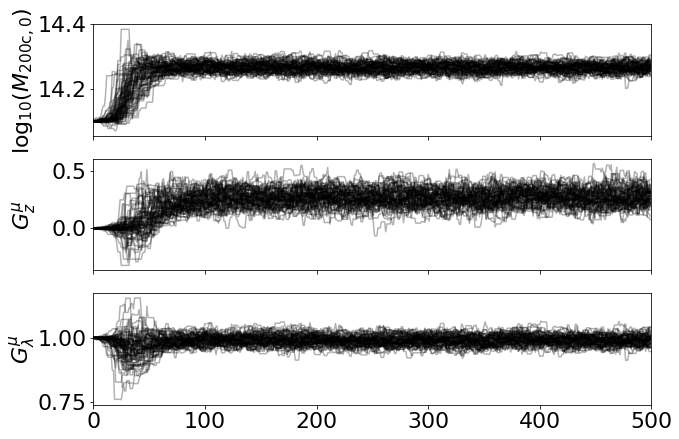

In [49]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = [r'$\log_{10}(M_{\rm 200c,0})$', r'$G_z^\mu$', r'$G_\lambda^\mu$']
samples = sampler.get_chain()
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [50]:
flat_samples = sampler.get_chain(discard=200, thin=1,flat=True)
flat_samples_limited = sampler_limited.get_chain(discard=200, thin=1,flat=True)

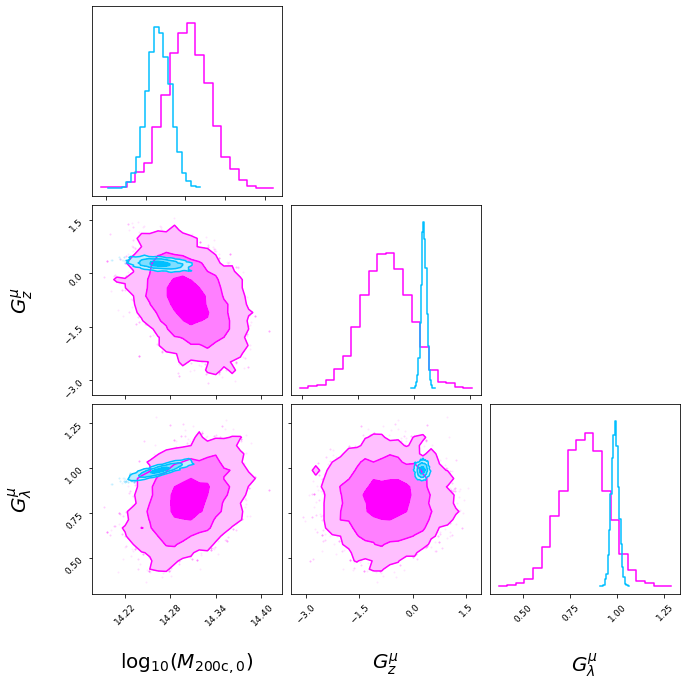

In [51]:
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
bins = 20
fig, axs = plt.subplots(len(labels), len(labels), figsize = (10,10))
for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 9)
        
fig = corner.corner(
    flat_samples_limited,
    bins=bins, levels=(sigma1, sigma2, sigma3),
    fig = fig,
                        smooth1d=False,smooth=False,plot_datapoints=True,
                  fill_contours=True,labels = labels,
                         
    color='magenta',
    label_kwargs={"fontsize": 20},
                  use_math_text=True,
                        plot_density=False,
                        max_n_ticks = 5,
);

        
fig = corner.corner(
    flat_samples,
    bins=bins, levels=(sigma1, sigma2, sigma3),
    fig = fig,
                        smooth1d=False,smooth=False,plot_datapoints=True,
                  fill_contours=True,labels = labels,
                         
    color='deepskyblue',
    label_kwargs={"fontsize": 20},
                  use_math_text=True,
                        plot_density=False,
                        max_n_ticks = 5,
);

In [52]:
np.mean(flat_samples,axis=0), np.median(flat_samples,axis=0)

(array([14.26654235,  0.26762941,  0.98983511]),
 array([14.26636473,  0.26562881,  0.9896498 ]))

In [53]:
np.mean(flat_samples_limited,axis=0), np.median(flat_samples_limited,axis=0)

(array([14.30277324, -0.73988049,  0.82496521]),
 array([14.30278517, -0.73740054,  0.82688845]))

In [54]:
mor_mean = 10**(mu_logM_lambda(z0, np.log10(ll), flat_samples[:,0].mean(), flat_samples[:,1].mean(), flat_samples[:,2].mean()))

In [55]:
mor_mean_limited = 10**(mu_logM_lambda(z0, np.log10(ll), flat_samples_limited[:,0].mean(), flat_samples_limited[:,1].mean(), flat_samples_limited[:,2].mean()))

In [56]:
mor_samples = np.vstack([10**(mu_logM_lambda(z0, np.log10(ll[i]), flat_samples[:,0], flat_samples[:,1], flat_samples[:,2])) for i in range(ll.size)])

In [57]:
mor_samples_limited = np.vstack([10**(mu_logM_lambda(z0, np.log10(ll[i]), flat_samples_limited[:,0], flat_samples_limited[:,1], flat_samples_limited[:,2])) for i in range(ll.size)])

NameError: name 'M_Saro' is not defined

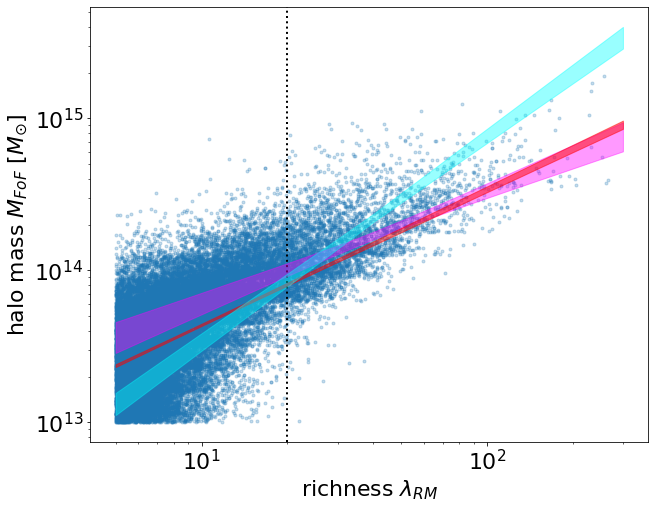

In [68]:
plt.loglog(mt1['mass'], mt2['mass'], '.',alpha=0.25)
plt.axvline(20, color='black', linestyle='dotted', lw=2)

plt.xlabel("richness $\\lambda_{RM}$")
plt.ylabel('halo mass $M_{FoF}$ [$M_{\odot}$]')


plt.fill_between(ll, np.percentile(mor_samples_limited,16, axis=1) , np.percentile(mor_samples_limited,84, axis=1), alpha=0.4, color='magenta', zorder=3, label='this work, 0.2<z<0.65, $\\lambda_{RM}$>20')
plt.fill_between(ll, np.percentile(mor_samples,16, axis=1) , np.percentile(mor_samples,84, axis=1), alpha=0.5, color='red', zorder=3, label='this work, all')


#adding parametrization from litterature
ll = np.logspace(np.log10(min_richness), np.log10(300))

z0 = 0.4
Om_z0 = cosmo.Om0   

plt.fill_between(ll, M_DES_Y1_lim(ll, z0, 'min', Om_z0),M_DES_Y1_lim(ll, z0, 'max', Om_z0),alpha=0.4, color='cyan', zorder=3, label='DES Y1 (M_200c) at z ='+str(z0) )
plt.plot(ll, M_Saro(ll, z0, Om_z0), 'k--', alpha=1, zorder=3, label='Saro+2015 at z ='+str(z0))

#plt.plot(ll, M_DES_Y1(ll, z0, Om_z0), 'b-', alpha=1, label='DES Y1 (M_200c) at z ='+str(z0) )
#plt.plot(ll, M_SDSS(ll, z0, Om_z0), 'g-.', alpha=1, label='SDSS (M_200c) at z ='+str(z0))
#plt.plot(ll, M_DES_SV(ll, z0, Om_z0), 'b--', alpha=1, label='DES SV (M_200c) at z ='+str(z0))

#plt.plot(ll, mor_mean, lw=4)


plt.legend(fontsize='x-small')